# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project 3: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [2]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


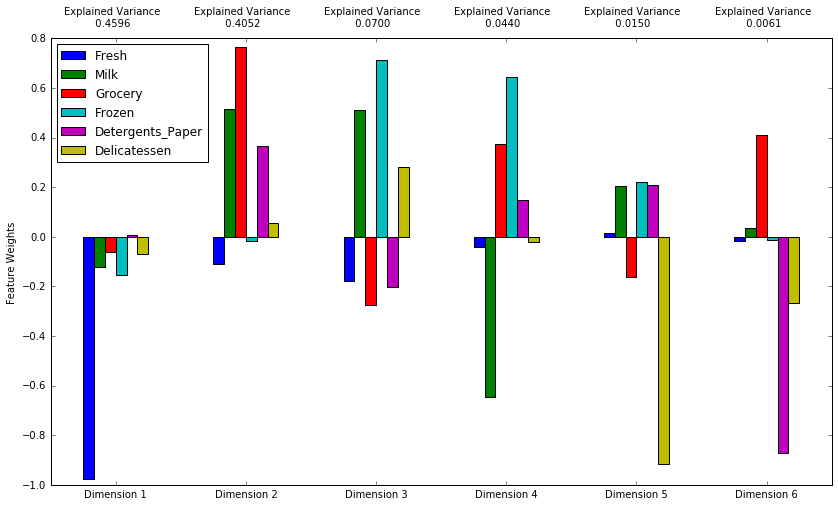

In [3]:
# My own initial curiosity: variance explained via PCA on raw data?
import sklearn
pca = sklearn.decomposition.PCA(len(data.columns))
pca.fit(data)
pca_results = rs.pca_results(data, pca)

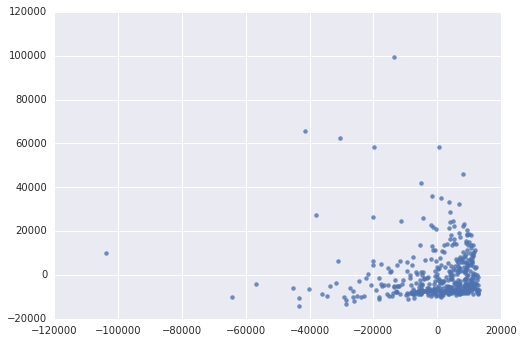

In [4]:
import seaborn as sns
projection = pca.transform(data)
sns.regplot(projection[:,0], projection[:,1],fit_reg=False)

### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [5]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [data['Frozen'].argmin(), data['Frozen'].argmax(), data['Fresh'].argmax()]
print indices
# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

[420, 325, 181]
Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,4456,5266,13227,25,6818,1393
1,32717,16784,13626,60869,1272,5609
2,112151,29627,18148,16745,4948,8550


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

**Answer:**
The first sample I selected spends the least on frozen items across the dataset. As it happens, they also do not spend much on fresh items. However they do spend a large on grocery and detergents, well above the mean. I am thinking this could be a small retailer.

The second sample I selected spends the most on frozen items across the dataset. I think this is probably also a restaurant, maybe a fast food chain.

The last sample maxes out the Fresh dimension. They are also well above the 75th percentile in other spending categories, so this seems like an very large organization. I assume this is a large restaurant chain.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [6]:
from sklearn.tree import DecisionTreeRegressor
# I am going to perform the above step for _each_ feature instead of just one
# It doesn't seem to make sense to just pick one feature for this kind of test
for feature in data.columns:
    new_data = data.drop(feature,axis=1)
    X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(new_data, data[feature], 
                                                                                test_size=0.25, random_state=99)
    regressor = DecisionTreeRegressor(random_state=99)
    regressor.fit(X_train, y_train)
    score = regressor.score(X_test, y_test)
    print "Score predicting feature %s: %f" % (feature, score) 

Score predicting feature Fresh: -0.709447
Score predicting feature Milk: 0.229326
Score predicting feature Grocery: 0.729561
Score predicting feature Frozen: -0.680407
Score predicting feature Detergents_Paper: 0.815004
Score predicting feature Delicatessen: -0.595981


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:**
I ran the holdout test on each feature in the dataset.

There seems to be some redundancy with the Grocery and/or the Detergents_Paper features. It may be that the two are linearly correlated. 

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

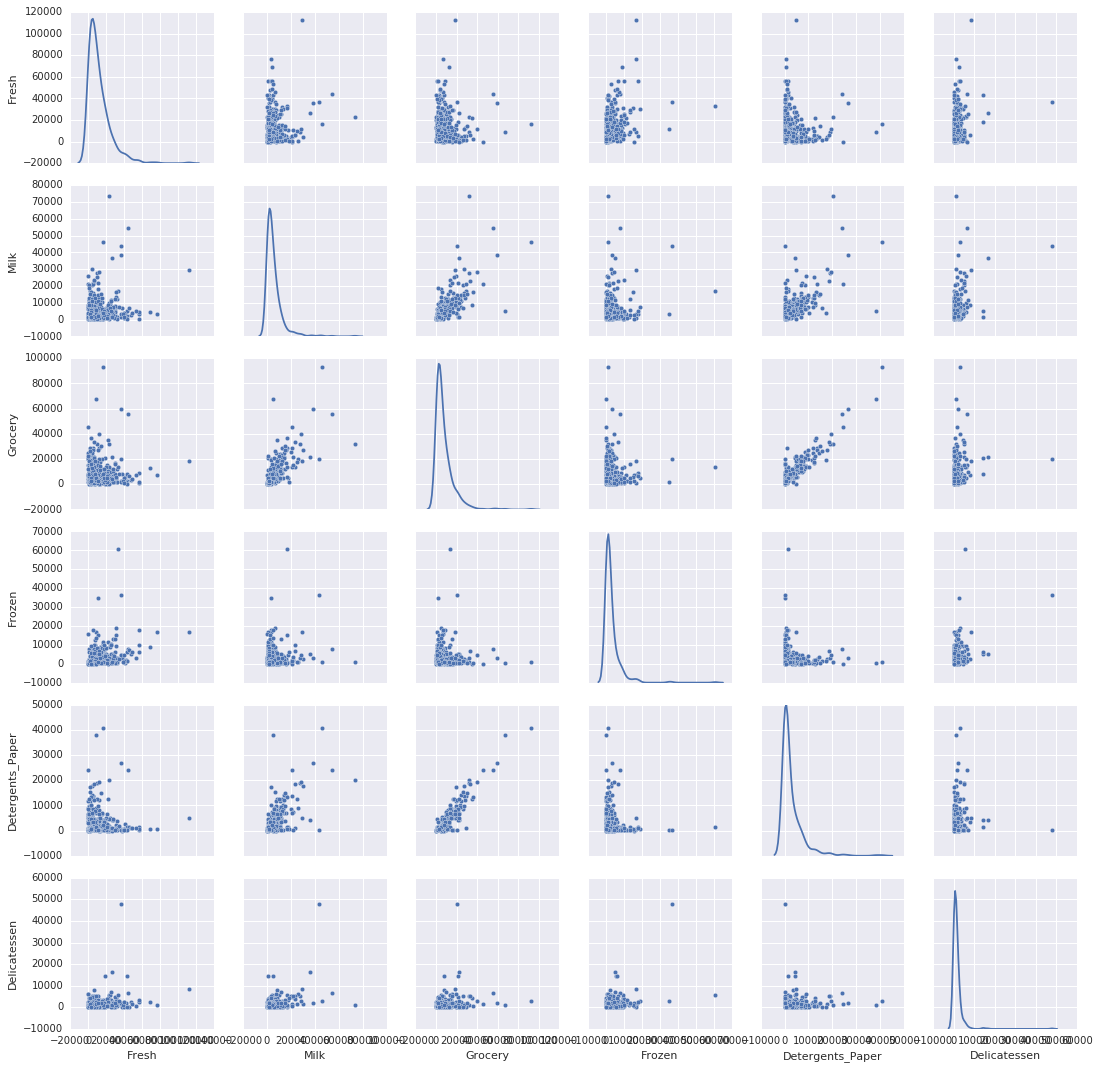

In [7]:
# Produce a scatter matrix for each pair of features in the data
# pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

# A previous grader encouraged me to try out the seaborn package
sns.pairplot(data, diag_kind='kde')

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:**

As we were clued into at above, the scatter plot for Grocery and Detergents_Paper show a strong linear trend. Grocery and Milk also show some correlation, albeit weaker and with more noise. This confirms my earlier suspicious, but may not be reason enough to withhold one of the features altogether... And even if we were to do that, we should further analyze which one would be better to retain, by determining which is least dependent on the other features.

The data distributions are skewed towards lower end of the price range. The mean and the median differ significantly for most features, with most data points well below the mean.

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log`.

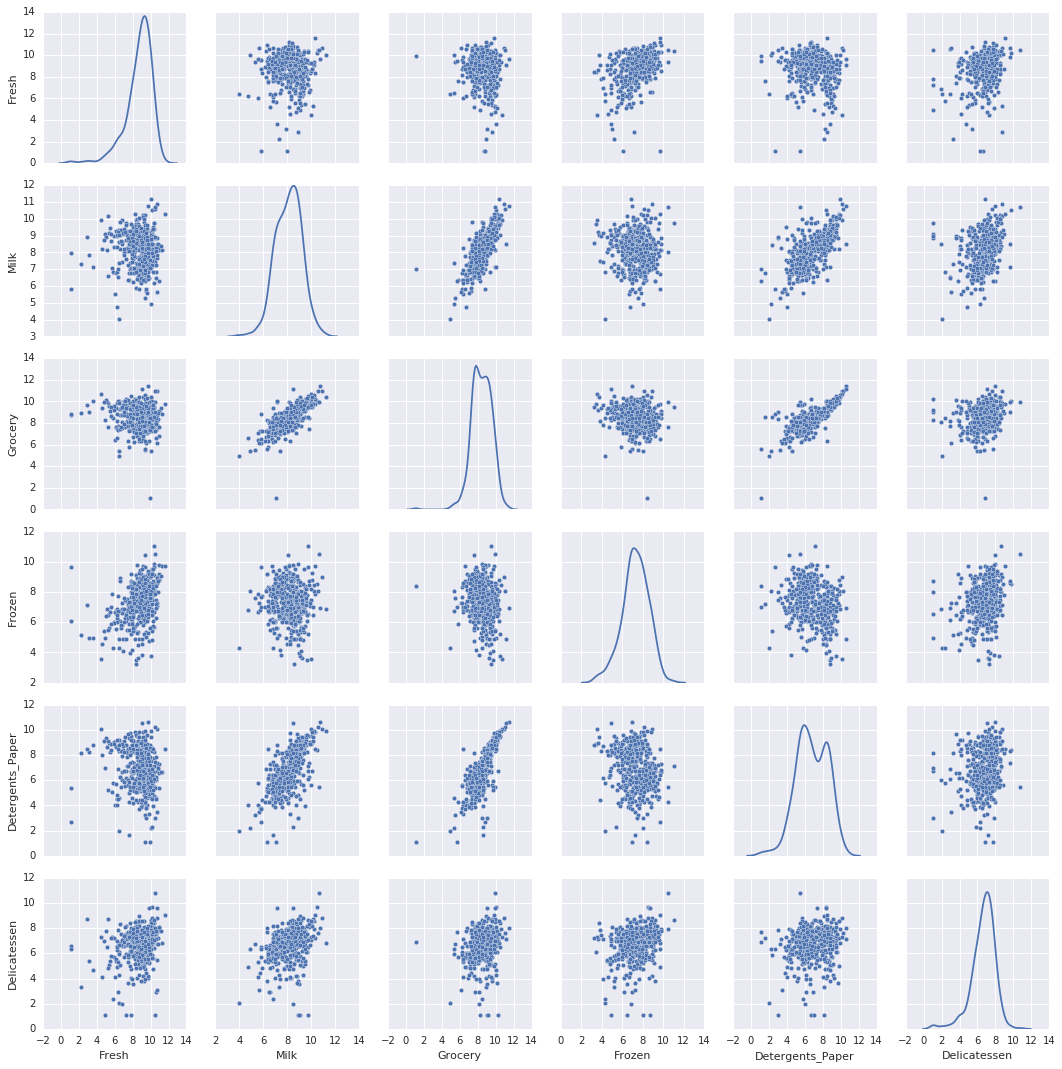

In [8]:
log_data = np.log(data)
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
# pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
sns.pairplot(log_data, diag_kind='kde')

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [9]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
1,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
2,11.627601,10.296441,9.806316,9.725855,8.506739,9.053687


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [10]:
# For each feature find the data points with extreme high or low values
outlier_dict = {}
two_steps = {}

for feature in log_data.keys():
    Q1 = np.percentile(log_data[feature], 25)
    Q3 = np.percentile(log_data[feature], 75)
    step = 1.5 * (Q3 - Q1)    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    outlier_dict[feature] = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    two_steps[feature] = log_data[~((log_data[feature] >= Q1 - 2*step) & (log_data[feature] <= Q3 + 2*step))]
    display(outlier_dict[feature])

outliers = reduce(np.union1d, map(lambda x: x.index.values, two_steps.values()))
print "Two steps away from IQR: " + str(outliers)

# Find those that appear in more than one outlier list
# Remove such points
outlier_index_lists = map(lambda x: x.index.values, outlier_dict.values())
outlier_indices = reduce(np.union1d, outlier_index_lists)
outlier_appearances = {}
for index in outlier_indices:
    for index_list in outlier_index_lists:
        if index in index_list:
            if index in outlier_appearances:
                outlier_appearances[index] += 1
            else:
                outlier_appearances[index] = 1
outliers = np.union1d(outliers, [o for o in outlier_indices if outlier_appearances[o] > 1])
print "Outliers to be removed are: %s" % (outliers)
# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)
good_data.describe()

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


Two steps away from IQR: [ 66  75  95 109 128 142 187 218 338]
Outliers to be removed are: [ 65  66  75  95 109 128 142 154 187 218 338]


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,8.817825,8.124814,8.448697,7.319444,6.813763,6.729866
std,1.296488,1.059489,1.046964,1.260485,1.670045,1.175367
min,3.135494,4.718499,5.384495,3.218876,1.098612,1.945910
25%,8.117312,7.354362,7.671827,6.651572,5.575949,6.035481
50%,9.060331,8.194229,8.463792,7.340187,6.700731,6.892642
75%,9.737197,8.867427,9.272940,8.174421,8.284252,7.510431
max,11.627601,11.205013,11.437986,11.016479,10.617099,10.777768


### Question 4
*Are there any data points considered outliers for more than one feature based on the definition above? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:**
I removed any data point which appeared as an outlier in more than one feature dimension or which were two steps away from the IQR in a single dimension. I decided that removing a data point for being an outlier in _just_ one dimension would remove too much information from the dataset.

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

Explained variance: [ 4.52033637  2.54828355  0.9962668   0.95066435  0.42495594  0.19586849]


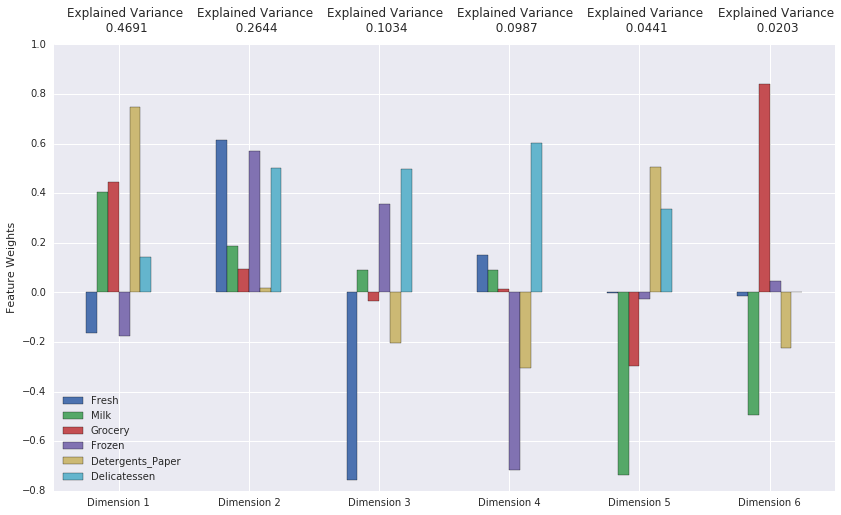

In [11]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = sklearn.decomposition.PCA(len(good_data.columns))
pca.fit(good_data)
# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)
# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)
# Print total variance
print "Explained variance: " + str(pca.explained_variance_)

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

**Answer:**
The first and second principal components combine to explain 73.35% of the variance. The first four explain 93.56%. 

The first component represents a dimension that is roughly split between milk, grocery, and/or detergents paper spending, with a heavier weight towards detergents paper. This spending behavior might be typical of grocery stores or large retail stock stores.

The second component captures fresh, frozen, and/or delicatessen spending. This might be the purchasing profile of a mid-tier restaurant (not fast food, not Michelen rated).

The third comonent indicates low spending on fresh items and high spending on frozen and/or delicatessen. This could be the proflie of a fast food restaurant/chain.

The fourth component caputres low spending on frozen items and high spending on delicatessen. This might be characteristic spending behavior of a cafe or deli restaurant.

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [12]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,3.0118,-2.1212,-1.3103,2.6198,0.6577,0.0213
1,0.7331,4.4408,1.1165,-1.2058,-0.7847,0.1770
2,2.1899,4.8310,-0.3060,-0.2014,-0.4278,-0.2441


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the reuslts to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [13]:
pca = sklearn.decomposition.PCA(2)
reduced_data = pca.fit_transform(good_data)
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [14]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,3.0118,-2.1212
1,0.7331,4.4408
2,2.1899,4.8310


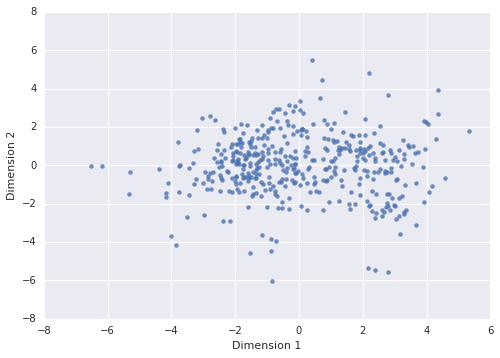

In [15]:
sns.regplot(reduced_data['Dimension 1'],reduced_data['Dimension 2'],fit_reg=False)

## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:**

K-means scales well to a large number of samples and minimizes the within-cluster sum-of-squares. The is a natural criteria to minimize: we want our clusters to be tightly packed when possible.

An advantage of GMM is that the algorithm maximizes only the likelihood, and therefore the resulting clusters will have less structural bias: K-means can be viewed as a special case of GMM with equal covariance per component [1]. Another advantage is that GMM performs "soft-clustering" which gives us the potential to view distributional qualities of the data instead of _only_ their predicted cluster label.

I'm opting to use GMM for the advantages listed, and because the data exploration done so far makes me think the customer segments may not cleanly separable and may even be overlapping, so I am preferential towards soft-clustering.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [16]:
from sklearn.mixture import GMM
from sklearn.metrics import silhouette_score

max_score = -2 # worst silhouette score is -1
arg_max = -1
for components in range(2, 6):
    clusterer = GMM(n_components=components, random_state=10)
    preds = clusterer.fit_predict(reduced_data)
    centers = clusterer.means_
    sample_preds = clusterer.predict(pca_samples)
    score = silhouette_score(reduced_data, preds)
    if score > max_score:
        max_score = score
        arg_max = components
    print score

clusterer = GMM(n_components=arg_max, random_state=10)
preds = clusterer.fit_predict(reduced_data)
centers = clusterer.means_
sample_preds = clusterer.predict(pca_samples)

print "Optimal number of clusters is %d with a score of %f." % (arg_max, max_score)

0.419347247195
0.312352588611
0.324465290857
0.281413044503
Optimal number of clusters is 2 with a score of 0.419347.


### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:**
The best silhouette score was acheived with *two* components, scoring 0.419347247195. Looking above at the plot of the PCA projection, I would agree that the most natural choice for number of clusters is two.

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

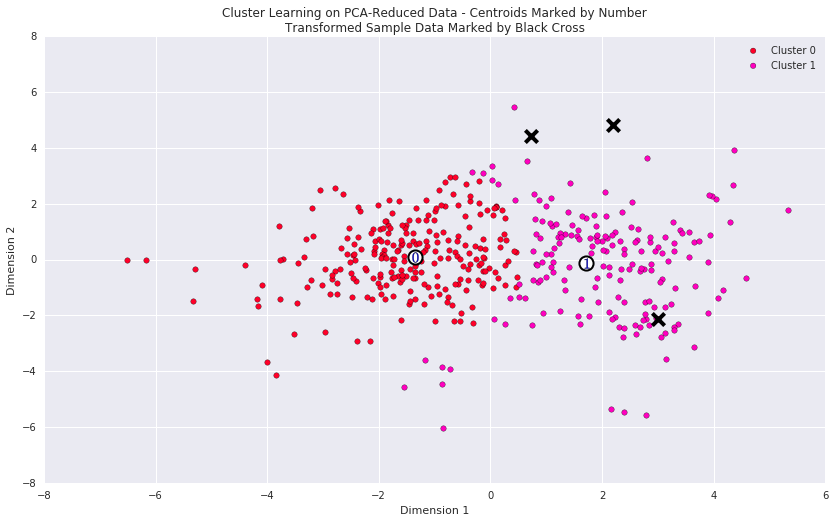

In [17]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [18]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)
true_centers = np.exp(log_centers)
# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8903.0,1989.0,2582.0,2010.0,332.0,722.0
Segment 1,4749.0,6633.0,9932.0,1048.0,3293.0,1010.0


### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:**
Segment 0 seems to represent restaurants, while Segment 1 represents retail stock stores. 

The purchase costs in each category for the Segment 0 representative are near the 50th percentile across the entire distribution for all dimensions except Detergents_Paper. Those for Segment 1 are close to the 75th percentile in Detergents_Paper, Grocery, and Milk. 

Going with the assumption that the segments roughly correspond to restaurants and retail stock stores, the fact that Segment 0 lies in the center of the overall data distribution suggests that the actual dataset contains _more_ examples of restaurants than of retail stock. 

### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [19]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 1


**Answer:**

These results contradict two of my predictions that the three points belong to restaurants. However, I think my original guesses are correct, and that these predictions can be attributed to: (1) discarded variance in the dimensionality reduction and (2) the scale at which my samples purchased. Two of my sample points (1 and 2) maximized Frozen and Fresh respectively, and therefore could have a high value in the derived dimension without having equal contribution from the original basis vectors. 

Sample point 0 minimized Frozen, but had a significant spending in grocery and detergents. So the prediction by the model agrees with mine.

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. *How can the wholesale distributor use the customer segments to determine which customers, if any, would reach positively to the change in delivery service?*  
**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:**

The distributor can split his two segments further into two groups each, and for one group in each segment switch the delivery frequency to 3 days per week. He/she can do this on a small subset of each category (say, 20%) and measure the change in total purchasing. Depending on the change in sales and the savings from less frequent deliviers, the distributor can decide whether to further implement the policy (possibly in a gradual manner to the rest of the segment) or to revert back fo the old schedule (possibly on a case-by-case basis, only for customers who react negatively).

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
*How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?*  
**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:**
One idea is to train a classifier (perhaps an SVC) on our dataset, using the customer segment as a binary target. Then future points could be classified, and we could even re-run our clustering algorithm to incorporate the new data points and retrain the classifier later. 

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

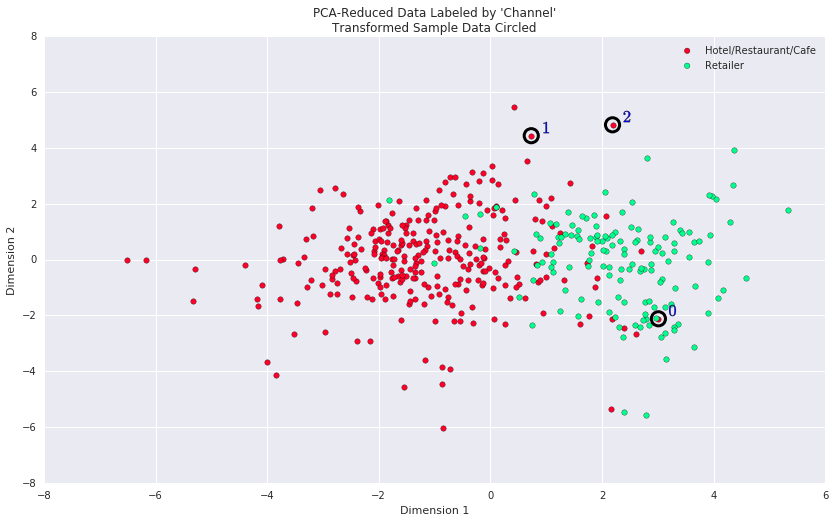

In [20]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**

The actual categories match almost exactly with my predictions! I did not consider hotels as a category, and to be honest I am not sure it makes sense to lump them in with restaurants and cafes. My mixture model captures the underlying distribution well: there is clearly a rough boundary along the first PCA component dimension separating HoReCa points from retailers.

Funnily enough, the sample points I selected _all_ belong to HoReCa. So my guesses got 2/3 and my model got 0/3 on these particular points. However, I am satisfied with the overall behavior of the model.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.